# Practical Machine Learning
# Lab 4
## Convolutional Neural Networks

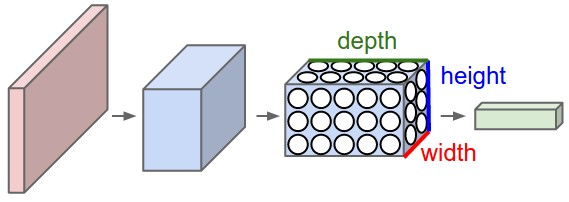

A ConvNet arranges its neurons in three dimensions (width, height, depth). Every layer of a ConvNet transforms the 3D input volume to a 3D output volume of neuron activations. In this example, the red input layer holds the image, so its width and height would be the dimensions of the image, and the depth would be 3 (Red, Green, Blue channels)

## Properties of the convolution layer
 - parameter sharing
    - in a fully connected neural network one weight is used only once during a forward step, but in a CNN one weight is used in each position of the input (when the stride is 1, excepting the edges)
 - local connectivity
     - each neuron (unit) is connected only to a small region, this region is named receptive field
 - equivariance to translation
     - if a filter learns to recognise a specific pattern, it will recognise that pattern no matter its location in the input
     
## Properties of the pooling layer
 - a pooling function replaces the output of the net at a certain location with a summary statistic of the nearby outputs
 - helps to make the representation approximately invariant to small translations of the input

In [34]:
import os
import numpy as np
from os import path
import matplotlib.pyplot as plt

ROOT_PATH = '..'
DATA_PATH = path.join(ROOT_PATH, 'data')
WEIGHTS_PATH = path.join(ROOT_PATH, 'weights')
CHECKPOINTS_PATH = path.join(ROOT_PATH, 'checkpoints')

os.environ['CUDA_VISIBLE_DEVICES']='0'

- Loading the images

In [35]:
# load the training data
train_images_raw = np.load(f'{DATA_PATH}/train_images.npy')
train_labels = np.load(f'{DATA_PATH}/train_labels.npy') 
print('The number of images for training is %d.' % train_images_raw.shape[0]) 

# load the test data
test_images_raw = np.load(f'{DATA_PATH}/test_images.npy')
test_labels = np.load(f'{DATA_PATH}/test_labels.npy') 

The number of images for training is 10000.


###  Prepare the data
Convert the data from uint8 to float32, normalize the pixel data from [0, 255] to [0, 1]

Compute the mean image and substract it from each training and test image.

In [36]:
# TODO: 2.1 convert int to float
train_images = train_images_raw.astype(np.float32) / 255.
test_images = test_images_raw.astype(np.float32) / 255.

# TODO: 2.2 compute mean training image
train_image_mean = train_images.mean(axis=(0,))
test_image_mean = train_image_mean

# TODO: 2.3 subtract the mean image from training and test data.
train_images = (train_images - train_images.mean(axis=0)) / train_images.std(axis=0)
test_images = (test_images - test_images.mean(axis=0)) / test_images.std(axis=0)

### Define a conv layer

In [37]:
import tensorflow
import tensorflow as tf
import tensorflow.keras.layers as layers

layers.Conv2D(filters=64, kernel_size=(5, 5), activation='relu', strides=(1,1), padding='same')
# filters - the number of conv filters
# kernel_size - the size of the kernel, we usually use odd numbers
# activation - the activation function
# strides - the stride on each dimension
# padding - same or valid

### Define a pooling layer

In [38]:
layers.AveragePooling2D(pool_size=3, strides=(2,2), padding='same') # average pooling
layers.MaxPool2D(pool_size=3, strides=(2,2), padding='same') # max pooling 
# pool_size - the size of the window
# strides - the stride on each dimension
# padding - same or valid

- Flatten layer - it flattens the input, but does not affect the batch size. 

In [39]:
layers.Flatten()

## Exercises

## 1. Train a convolutional neural network with the following configuration:
    - L1: conv
        - kernel-size=3, stride=1, padding=same, filters=32, activation-function=relu
    - L2: conv
        - kernel-size=3, stride=1, padding=same, filters=32, activation-function=relu
    - L3: pool
        - kernel-size=2, stride=2, padding=same
    - L4: conv
        - kernel-size=3, stride=1, padding=same, filters=64, activation-function=relu
    - L5: conv
        - kernel-size=3, stride=1, padding=same, filters=64, activation-function=relu
    - L6: pool
        - kernel-size=2, stride=2, padding=same
    - L7: conv
        - kernel-size=3, stride=1, padding=same, filters=128, activation-function=relu
    - L8: conv
        - kernel-size=3, stride=1, padding=same, filters=128, activation-function=relu
    - L9: pool
        - kernel-size=2, stride=2, padding=same
    - L10: flatten
    - L11: dropout
        - dropout rate=0.3
    - L12 - fully connected (dense) with 10 units and softmax as activation function.
 
Train the network for 10 epochs using what optimizer you like.

The loss you have to use is 'categorical_crossentropy' (you should encode the training labels using one-hot-encoding in order to use this loss).

Does this network perform better than a fully connected one?
    

In [50]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.losses import CategoricalCrossentropy
from nvitop.callbacks.keras import GpuStatsLogger

# 1.1 encode the training labels in one-hot
train_labels_one_hot = tf.raw_ops.OneHot(indices=train_labels, depth=10, on_value=1.0, off_value=.0)
test_labels_one_hot = tf.raw_ops.OneHot(indices=test_labels, depth=10, on_value=1.0, off_value=.0)

# 1.2 define the cnn
cnn_model = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer((32, 32, 3)),
  tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', strides=1),
  tf.keras.layers.LeakyReLU(),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', strides=1),
  tf.keras.layers.LeakyReLU(),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', strides=2),
  tf.keras.layers.LeakyReLU(),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', strides=1),
  tf.keras.layers.LeakyReLU(),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', strides=1),
  tf.keras.layers.LeakyReLU(),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Conv2D(filters=128, kernel_size=3, padding='same', strides=2),
  tf.keras.layers.LeakyReLU(),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Conv2D(filters=128, kernel_size=3, padding='same', strides=1),
  tf.keras.layers.LeakyReLU(),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Conv2D(filters=128, kernel_size=3, padding='same', strides=1),
  tf.keras.layers.LeakyReLU(),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Conv2D(filters=256, kernel_size=3, padding='same', strides=2),
  tf.keras.layers.LeakyReLU(),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(2048),
  tf.keras.layers.LeakyReLU(),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(2048),
  tf.keras.layers.LeakyReLU(),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(10, activation='softmax')
])

# 1.3 compile the cnn
cnn_model.compile(optimizer=Adam(learning_rate=1e-3, weight_decay=1e-4),
                  loss=CategoricalCrossentropy(),
                  metrics=[CategoricalAccuracy()])

# 1.4 train the cnn
valid_fr = 1e-2
train_in = valid_in = int((1 - valid_fr) * train_images.shape[0])
cnn_model.fit(train_images[:train_in], train_labels_one_hot[:train_in],
              validation_data=(train_images[train_in:], train_labels_one_hot[train_in:]),
              batch_size=512, epochs=100, initial_epoch=0,
              callbacks=[
                tf.keras.callbacks.TensorBoard(ROOT_PATH + '/logs', write_graph=True),
                GpuStatsLogger(['/gpu:0'])
              ])

# 1.5 evaluate the cnn
test_loss, test_accuracy = cnn_model.evaluate(test_images, test_labels_one_hot, batch_size=128)
print('test_accuracy = ', test_accuracy)
print('test_loss = ', test_loss)

Epoch 1/100


2022-11-19 23:09:43.659982: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_21/dropout_117/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


20/20 [==============================] - 3s 42ms/step - loss: 2.2879 - categorical_accuracy: 0.1470 - gpu_id: 0/utilization.memory (%): 7.0000 - gpu_id: 0/utilization.gpu (%): 75.0000 - gpu_id: 0/memory.used (MiB): 23991.4375 - gpu_id: 0/memory.free (MiB): 230.3750 - val_loss: 2.1537 - val_categorical_accuracy: 0.2600
Epoch 2/100
20/20 [==============================] - 1s 29ms/step - loss: 1.9912 - categorical_accuracy: 0.2721 - gpu_id: 0/utilization.memory (%): 37.8000 - gpu_id: 0/utilization.gpu (%): 86.9000 - gpu_id: 0/memory.used (MiB): 23917.6750 - gpu_id: 0/memory.free (MiB): 304.1375 - val_loss: 1.8512 - val_categorical_accuracy: 0.3000
Epoch 3/100
20/20 [==============================] - 1s 30ms/step - loss: 1.7788 - categorical_accuracy: 0.3529 - gpu_id: 0/utilization.memory (%): 51.0000 - gpu_id: 0/utilization.gpu (%): 92.0000 - gpu_id: 0/memory.used (MiB): 23886.0625 - gpu_id: 0/memory.free (MiB): 335.7500 - val_loss: 1.8364 - val_categorical_accuracy: 0.3300
Epoch 4/100
20

## 2. Train again the previous network, but without the dropout layer. What do you notice?

In [41]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.losses import CategoricalCrossentropy
from nvitop.callbacks.keras import GpuStatsLogger

# 1.1 encode the training labels in one-hot
train_labels_one_hot = tf.raw_ops.OneHot(indices=train_labels, depth=10, on_value=1.0, off_value=.0)
test_labels_one_hot = tf.raw_ops.OneHot(indices=test_labels, depth=10, on_value=1.0, off_value=.0)

# 1.2 define the cnn
cnn_model = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer((32, 32, 3)),
  tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', strides=1),
  tf.keras.layers.LeakyReLU(),
  tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', strides=1),
  tf.keras.layers.LeakyReLU(),
  tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', strides=2),
  tf.keras.layers.LeakyReLU(),
  tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', strides=1),
  tf.keras.layers.LeakyReLU(),
  tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', strides=1),
  tf.keras.layers.LeakyReLU(),
  tf.keras.layers.Conv2D(filters=128, kernel_size=3, padding='same', strides=2),
  tf.keras.layers.LeakyReLU(),
  tf.keras.layers.Conv2D(filters=128, kernel_size=3, padding='same', strides=1),
  tf.keras.layers.LeakyReLU(),
  tf.keras.layers.Conv2D(filters=128, kernel_size=3, padding='same', strides=1),
  tf.keras.layers.LeakyReLU(),
  tf.keras.layers.Conv2D(filters=256, kernel_size=3, padding='same', strides=2),
  tf.keras.layers.LeakyReLU(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(2048),
  tf.keras.layers.LeakyReLU(),
  tf.keras.layers.Dense(2048),
  tf.keras.layers.LeakyReLU(),
  tf.keras.layers.Dense(10, activation='softmax')
])

# 1.3 compile the cnn
cnn_model.compile(optimizer=Adam(learning_rate=1e-3),
                  loss=CategoricalCrossentropy(),
                  metrics=[CategoricalAccuracy()])

# 1.4 train the cnn
valid_fr = 1e-1
train_in = valid_in = int((1 - valid_fr) * train_images.shape[0])
cnn_model.fit(train_images[:train_in], train_labels_one_hot[:train_in],
              validation_data=(train_images[train_in:], train_labels_one_hot[train_in:]),
              batch_size=64, epochs=20, initial_epoch=0,
              callbacks=[
                tf.keras.callbacks.TensorBoard(ROOT_PATH + '/logs', write_graph=True),
                GpuStatsLogger(['/gpu:0'])
              ])

# 1.5 evaluate the cnn
test_loss, test_accuracy = cnn_model.evaluate(test_images, test_labels_one_hot, batch_size=128)
print('test_accuracy = ', test_accuracy)
print('test_loss = ', test_loss)

Epoch 1/20
141/141 [==============================] - 3s 8ms/step - loss: 1.8714 - categorical_accuracy: 0.3050 - gpu_id: 0/utilization.memory (%): 5.0000 - gpu_id: 0/utilization.gpu (%): 44.0000 - gpu_id: 0/memory.used (MiB): 23788.9375 - gpu_id: 0/memory.free (MiB): 432.8750 - val_loss: 1.7082 - val_categorical_accuracy: 0.3730
Epoch 2/20
141/141 [==============================] - 1s 6ms/step - loss: 1.5500 - categorical_accuracy: 0.4361 - gpu_id: 0/utilization.memory (%): 27.0000 - gpu_id: 0/utilization.gpu (%): 83.0000 - gpu_id: 0/memory.used (MiB): 23850.4375 - gpu_id: 0/memory.free (MiB): 371.3750 - val_loss: 1.4436 - val_categorical_accuracy: 0.4540
Epoch 3/20
141/141 [==============================] - 1s 6ms/step - loss: 1.3713 - categorical_accuracy: 0.4976 - gpu_id: 0/utilization.memory (%): 23.9929 - gpu_id: 0/utilization.gpu (%): 77.7376 - gpu_id: 0/memory.used (MiB): 23781.2744 - gpu_id: 0/memory.free (MiB): 440.5381 - val_loss: 1.3239 - val_categorical_accuracy: 0.5140
Ep